In [1]:
import torch
import gpytorch

import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

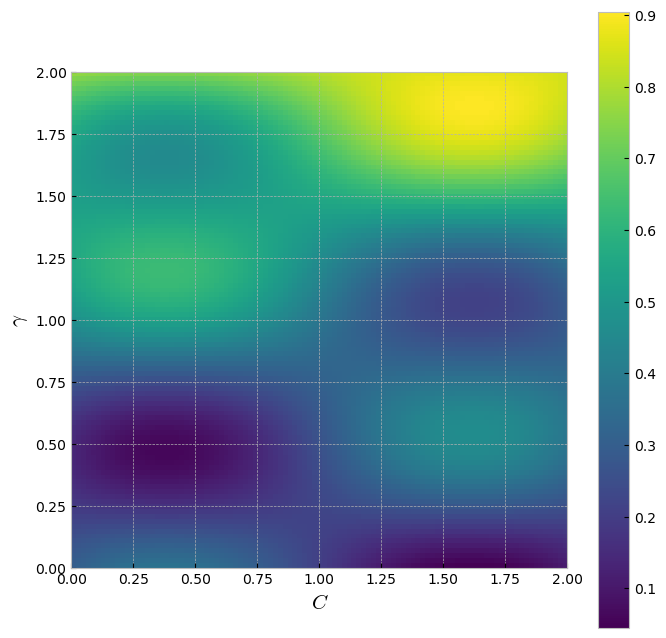

In [2]:
def f(x):
    return (
        torch.sin(5 * x[..., 0] / 2 - 2.5) * torch.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2


lb = 0
ub = 2
xs = torch.linspace(lb, ub, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing="ij")
xs = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = f(xs)

plt.figure(figsize=(8, 8))

plt.imshow(ys.reshape(101, 101).T, origin="lower", extent=[lb, ub, lb, ub])
plt.xlabel("$C$", fontsize=15)
plt.ylabel("$\gamma$", fontsize=15)
plt.colorbar()

plt.show()

In [3]:
torch.manual_seed(0)
train_x = torch.rand(size=(100, 2)) * 2
train_y = f(train_x)

In [4]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2)  # None or 2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
# declare the GP
noise = 1e-4

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# fix the hyperparameters
model.likelihood.noise = noise

# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()
    losses.append(loss.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

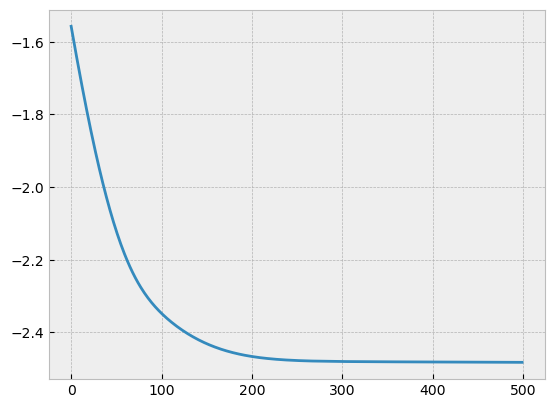

In [6]:
plt.plot(losses);

In [7]:
model.covar_module.base_kernel.lengthscale

tensor([[1.6960, 0.8739]], grad_fn=<SoftplusBackward0>)